# Elastic Net [vif5]
ElasticNet is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of and using the l1_ratio parameter.

https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

ElasticNet()

{'alpha': 1.0,   
 'copy_X': True,   
 'fit_intercept': True,   
 'l1_ratio': 0.5,   
 'max_iter': 1000,   
 'normalize': 'deprecated',   
 'positive': False,   
 'precompute': False,   
 'random_state': None,   
 'selection': 'cyclic',   
 'tol': 0.0001,   
 'warm_start': False}   
 
**_bayesian hyperparameter tuning_**

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import platform
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize, space
import sys

from validation import cross_validation
from validation import performance_test_shifted

date_format = '%Y-%m-%d'

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

In [2]:
# config 'all', 'vif_5' or 'vif_10'
vif = 'vif_5'

# config model
ml_algorithm = ElasticNet
filename = 'single-model_tau_en'

In [3]:
my_os = platform.system()
print('OS in my system: ',my_os)

if my_os == 'Windows':
    path = str(pathlib.Path().absolute()) + '\\'
    slash = '\\'
else:
    path = str(pathlib.Path().absolute()) + '/'
    slash = '/'

path_3 = path.replace('4_modelling', '3_data_pre-processing')

OS in my system:  Linux


## Load Data

In [4]:
data_set = pd.read_csv(path_3 + 'data_artifacts' + slash + 'data_set_e_spx_3-' + vif + '.csv', index_col=0)

## Original Target Model (no forecast horizon)
### Time Series Cross Validation on Default Model

In [5]:
default_model = ml_algorithm(random_state=23)
default_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': 23,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [6]:
default_model_scores_ori = cross_validation (data_set, default_model, 'tau_target_ori')
pd.DataFrame(default_model_scores_ori).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000
mean,0.027880,0.029523,0.136403,0.139654,0.0,-0.281342
std,0.001656,0.008054,0.003721,0.028160,0.0,0.327412
min,0.024467,0.022177,0.129251,0.114897,0.0,-1.157235
25%,0.026947,0.023585,0.134445,0.118732,0.0,-0.317034
50%,0.027967,0.026608,0.136745,0.128968,0.0,-0.175782
75%,0.029052,0.031176,0.138914,0.151260,0.0,-0.127222
max,0.029906,0.045619,0.141504,0.191687,0.0,-0.001093


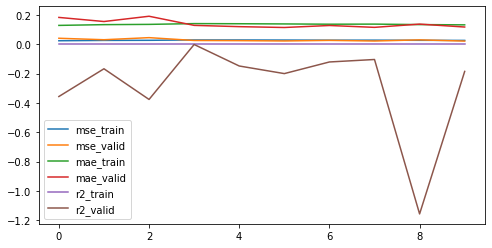

In [7]:
ax = pd.DataFrame(default_model_scores_ori).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [8]:
# search space for the hyperparameters
space = [space.Real(0.0001, 1, name='alpha'), 
         space.Real(0.0001, 1, name='l1_ratio')]

Optimal point: [0.00018308280393208325, 0.975957247005574]
Function value at optimal point: 0.004680893312850774


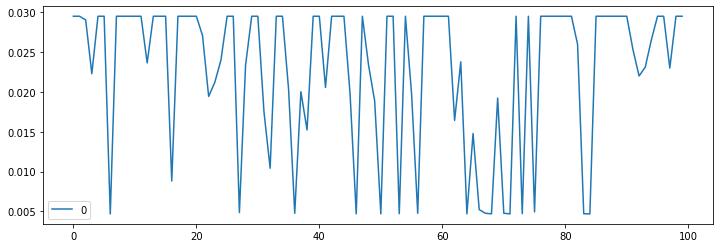

In [9]:
# objective function to minimize
def objective(params):
    alpha, l1_ratio = params
    model = ml_algorithm(alpha=alpha, l1_ratio=l1_ratio, max_iter=7000, random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_ori')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='lbfgs', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [10]:
# ---------------- config opt model -----------------
opt_model_ori = ml_algorithm(alpha=0.00018308280393208325, l1_ratio=0.975957247005574, max_iter=7000, random_state=23)

In [11]:
opt_model_ori_tscv_scores = cross_validation(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_tscv_scores = pd.DataFrame(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.003789,0.002505,0.048255,0.038359,0.845142,0.918026
1,0.003582,0.003890,0.046525,0.049212,0.866139,0.855580
2,0.003352,0.004581,0.044966,0.054133,0.877902,0.861812
3,0.003459,0.009419,0.045728,0.082191,0.884338,0.641479
4,0.004061,0.008175,0.049553,0.077211,0.863563,0.627158
5,0.004518,0.002870,0.053246,0.041076,0.845461,0.850675
6,0.004461,0.002592,0.052984,0.040555,0.843189,0.892120
7,0.004343,0.002452,0.052058,0.038944,0.847604,0.880855
8,0.004054,0.007189,0.049752,0.068697,0.852492,0.490104
9,0.004395,0.003136,0.052199,0.044516,0.835857,0.832484


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.004002,0.004681,0.049527,0.053489,0.856169,0.785029
std,0.000434,0.002610,0.003078,0.016596,0.016070,0.144639
min,0.003352,0.002452,0.044966,0.038359,0.835857,0.490104
25%,0.003633,0.002661,0.046958,0.040685,0.845222,0.689230
50%,0.004058,0.003513,0.049653,0.046864,0.850048,0.853127
75%,0.004382,0.006537,0.052164,0.065056,0.865495,0.876095
max,0.004518,0.009419,0.053246,0.082191,0.884338,0.918026


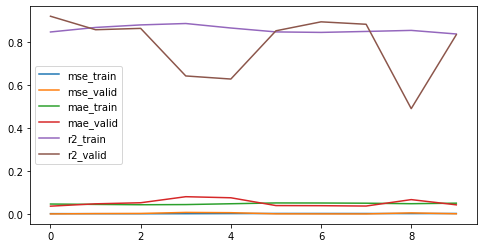

In [12]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

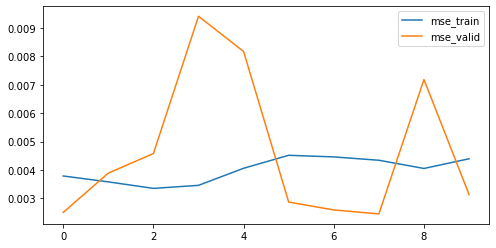

In [13]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

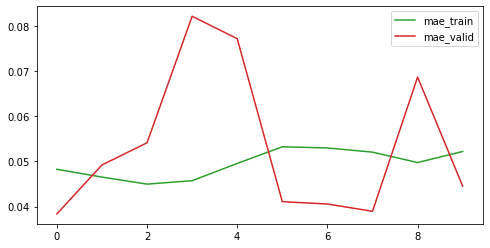

In [14]:
ax = opt_model_ori_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

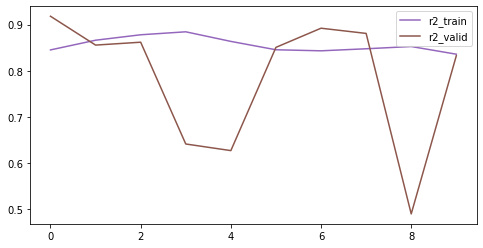

In [15]:
ax = opt_model_ori_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [16]:
opt_model_ori_test_scores = performance_test_shifted(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_test_scores = pd.DataFrame(opt_model_ori_test_scores)
display(opt_model_ori_test_scores)
display(opt_model_ori_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.003603,0.003914,0.046793,0.049396,0.864712,0.854706,0.366445,0.391789
1,0.003606,0.004560,0.046777,0.054081,0.868106,0.862463,0.425448,0.401961
2,0.003492,0.009405,0.046014,0.082071,0.882896,0.642012,0.330819,0.393131
3,0.004171,0.008347,0.050473,0.078131,0.858134,0.619325,0.286654,0.357305
4,0.004416,0.002859,0.052521,0.041009,0.848142,0.851218,0.281294,0.285722
5,0.004316,0.002581,0.051782,0.040453,0.847626,0.892575,0.288558,0.272738
6,0.004235,0.002463,0.051312,0.038973,0.849704,0.880336,0.291026,0.287547
7,0.004100,0.007678,0.050299,0.071359,0.851867,0.455445,0.199579,0.261571
8,0.004366,0.003087,0.051861,0.043967,0.841759,0.835102,0.245124,0.233902
9,0.004230,0.003160,0.051056,0.045413,0.838262,0.848116,0.245513,0.219476


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.004053,0.004805,0.049889,0.054485,0.855121,0.774130,0.296046,0.310514
std,0.000349,0.002639,0.002417,0.016475,0.013535,0.148218,0.064764,0.069206
min,0.003492,0.002463,0.046014,0.038973,0.838262,0.455445,0.199579,0.219476
25%,0.003729,0.002916,0.047670,0.041748,0.847755,0.690284,0.254458,0.264363
50%,0.004201,0.003537,0.050765,0.047404,0.850786,0.849667,0.287606,0.286634
75%,0.004295,0.006898,0.051665,0.067039,0.863067,0.860524,0.320871,0.383168
max,0.004416,0.009405,0.052521,0.082071,0.882896,0.892575,0.425448,0.401961


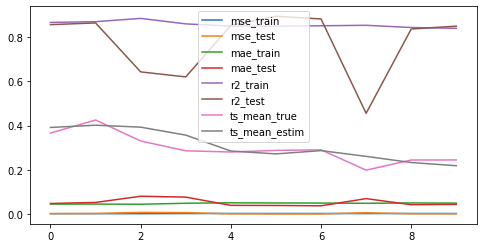

In [17]:
ax = opt_model_ori_test_scores.plot(figsize=(8,4))

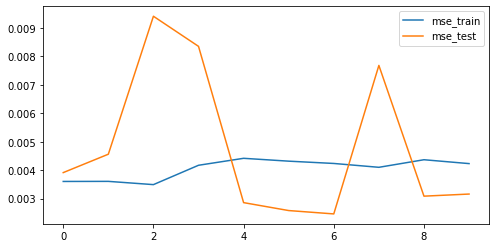

In [18]:
ax = opt_model_ori_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

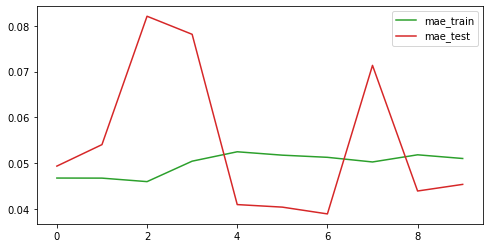

In [19]:
ax = opt_model_ori_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

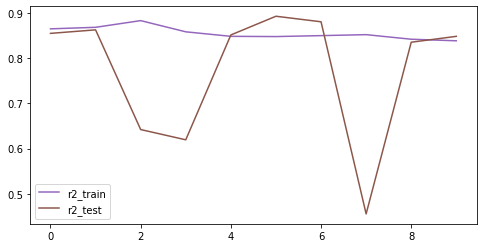

In [20]:
ax = opt_model_ori_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

In [21]:
opt_model_ori_test_scores

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.003603,0.003914,0.046793,0.049396,0.864712,0.854706,0.366445,0.391789
1,0.003606,0.004560,0.046777,0.054081,0.868106,0.862463,0.425448,0.401961
2,0.003492,0.009405,0.046014,0.082071,0.882896,0.642012,0.330819,0.393131
3,0.004171,0.008347,0.050473,0.078131,0.858134,0.619325,0.286654,0.357305
4,0.004416,0.002859,0.052521,0.041009,0.848142,0.851218,0.281294,0.285722
5,0.004316,0.002581,0.051782,0.040453,0.847626,0.892575,0.288558,0.272738
6,0.004235,0.002463,0.051312,0.038973,0.849704,0.880336,0.291026,0.287547
7,0.004100,0.007678,0.050299,0.071359,0.851867,0.455445,0.199579,0.261571
8,0.004366,0.003087,0.051861,0.043967,0.841759,0.835102,0.245124,0.233902
9,0.004230,0.003160,0.051056,0.045413,0.838262,0.848116,0.245513,0.219476


(0.2, 0.45)

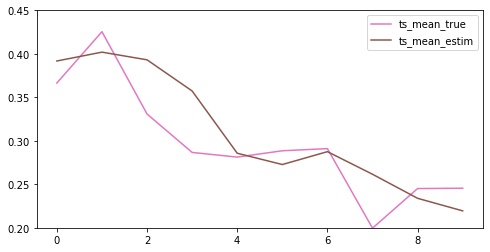

In [22]:
ax = opt_model_ori_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [23]:
results_ori = {'Model': [opt_model_ori],
            'fc_horizon': 0,
            'vif': [vif],
            'mse_tscv_t': [opt_model_ori_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_ori_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_ori_test_scores.mse_train.mean()],
            'mse_test': [opt_model_ori_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_ori_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_ori_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_ori_test_scores.mae_train.mean()],
            'mae_test': [opt_model_ori_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_ori_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_ori_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_ori_test_scores.r2_train.mean()],
            'r2_test': [opt_model_ori_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_ori.get_params()],
            'ts_mean_true': opt_model_ori_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_ori_test_scores.ts_mean_estim.mean(),
              }

## ----------------------------------------------------------
## Predicted Target Model (one year forecast horizon)
### Time Series Cross Validation on Default Model

In [24]:
default_model_scores_hor = cross_validation (data_set, default_model, 'tau_target_hor')
pd.DataFrame(default_model_scores_hor).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000
mean,0.027540,0.027336,0.134596,0.132017,0.0,-0.253414
std,0.001493,0.007255,0.003881,0.024994,0.0,0.331503
min,0.025133,0.022326,0.127670,0.112634,0.0,-1.156883
25%,0.026501,0.022588,0.131786,0.117745,0.0,-0.194664
50%,0.027556,0.025065,0.134846,0.122276,0.0,-0.144827
75%,0.028700,0.028926,0.137419,0.134389,0.0,-0.113195
max,0.029472,0.045869,0.139845,0.192933,0.0,-0.000813


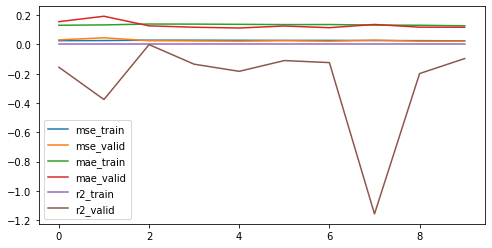

In [25]:
ax = pd.DataFrame(default_model_scores_hor).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

Optimal point: [0.000556534412323193, 0.9992594109074393]
Function value at optimal point: 0.009196152393723706


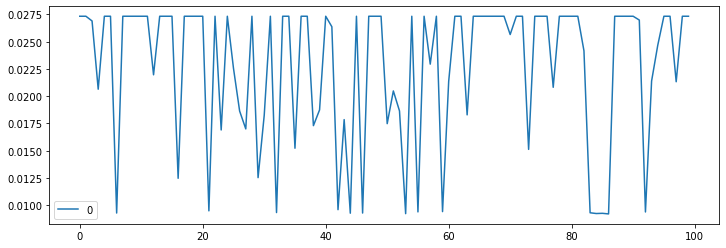

In [26]:
# objective function to minimize
def objective(params):
    alpha, l1_ratio = params
    model = ml_algorithm(alpha=alpha, l1_ratio=l1_ratio, max_iter=7000, random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_hor')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='lbfgs', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [27]:
# ---------------- config opt model -----------------
opt_model_hor = ml_algorithm(alpha=0.000556534412323193, l1_ratio=0.9992594109074393, max_iter=7000, random_state=23)

In [28]:
opt_model_hor_tscv_scores = cross_validation(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_tscv_scores = pd.DataFrame(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.008128,0.006266,0.072827,0.060168,0.687306,0.769775
1,0.007577,0.009816,0.069576,0.080143,0.717801,0.705586
2,0.007816,0.016128,0.070329,0.106458,0.734805,0.371772
3,0.008985,0.013781,0.076075,0.101358,0.694420,0.360205
4,0.009621,0.010360,0.079680,0.084178,0.666831,0.457138
5,0.009866,0.005766,0.080832,0.060234,0.649744,0.755911
6,0.009480,0.005487,0.078642,0.058538,0.663161,0.724262
7,0.008433,0.013065,0.073315,0.094853,0.687314,0.055302
8,0.008259,0.005802,0.072202,0.061328,0.686972,0.688518
9,0.007853,0.005489,0.069809,0.059167,0.687540,0.733923


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008602,0.009196,0.074329,0.076642,0.687589,0.562239
std,0.000827,0.004016,0.004209,0.019174,0.025054,0.239891
min,0.007577,0.005487,0.069576,0.058538,0.649744,0.055302
25%,0.007922,0.005775,0.070797,0.060184,0.671866,0.393113
50%,0.008346,0.008041,0.073071,0.070736,0.687310,0.697052
75%,0.009356,0.012389,0.078000,0.092184,0.692700,0.731507
max,0.009866,0.016128,0.080832,0.106458,0.734805,0.769775


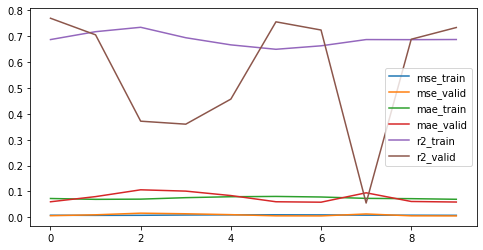

In [29]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

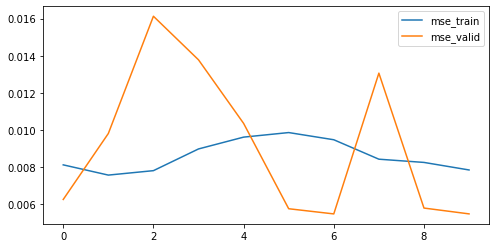

In [30]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

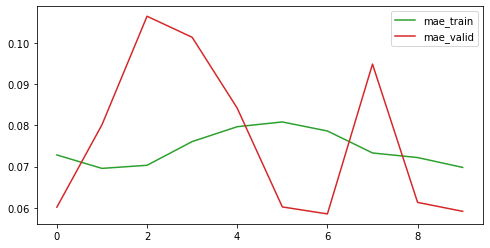

In [31]:
ax = opt_model_hor_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

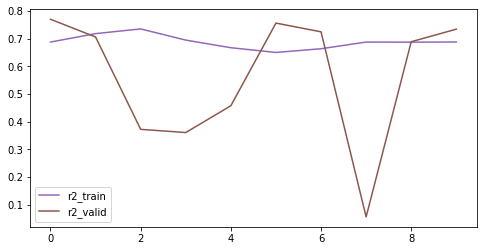

In [32]:
ax = opt_model_hor_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [33]:
opt_model_hor_test_scores = performance_test_shifted(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_test_scores = pd.DataFrame(opt_model_hor_test_scores)
display(opt_model_hor_test_scores)
display(opt_model_hor_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.007880,0.009958,0.071189,0.080954,0.704567,0.701341,0.429797,0.390609
1,0.007794,0.016112,0.070397,0.106388,0.734459,0.372403,0.335499,0.418709
2,0.008773,0.013466,0.075211,0.099972,0.696702,0.374861,0.293080,0.386713
3,0.009450,0.010098,0.078887,0.082734,0.670190,0.470877,0.287144,0.356233
4,0.009622,0.005698,0.079686,0.060033,0.655789,0.758800,0.295090,0.309868
5,0.009281,0.005564,0.077833,0.058781,0.666802,0.720430,0.292463,0.297846
6,0.008893,0.014724,0.075706,0.101378,0.673990,-0.064610,0.205042,0.300569
7,0.008849,0.006018,0.075124,0.062484,0.673016,0.676970,0.247086,0.257623
8,0.007931,0.005418,0.070719,0.058434,0.692530,0.737360,0.248710,0.239233
9,0.007538,0.019679,0.068429,0.123242,0.695893,-0.054924,0.342639,0.226972


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008601,0.010673,0.074318,0.083440,0.686394,0.469351,0.297655,0.318438
std,0.000757,0.005119,0.003919,0.023412,0.023071,0.315151,0.062015,0.067088
min,0.007538,0.005418,0.068429,0.058434,0.655789,-0.064610,0.205042,0.226972
25%,0.007893,0.005778,0.070836,0.060646,0.670896,0.373017,0.258318,0.267679
50%,0.008811,0.010028,0.075168,0.081844,0.683260,0.573923,0.292772,0.305218
75%,0.009184,0.014409,0.077301,0.101026,0.696500,0.715658,0.325397,0.379093
max,0.009622,0.019679,0.079686,0.123242,0.734459,0.758800,0.429797,0.418709


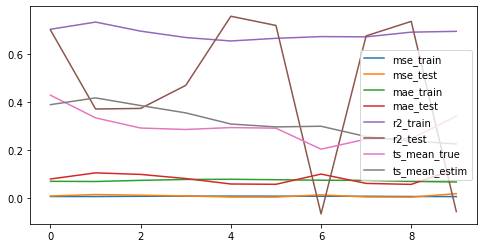

In [34]:
ax = opt_model_hor_test_scores.plot(figsize=(8,4))

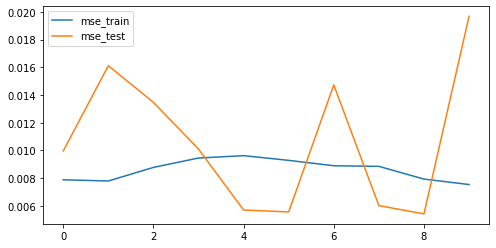

In [35]:
ax = opt_model_hor_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

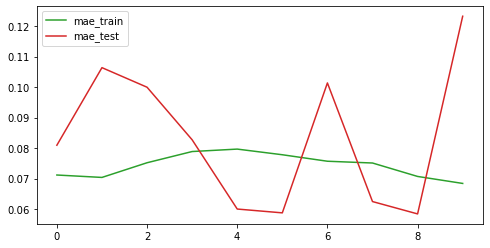

In [36]:
ax = opt_model_hor_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

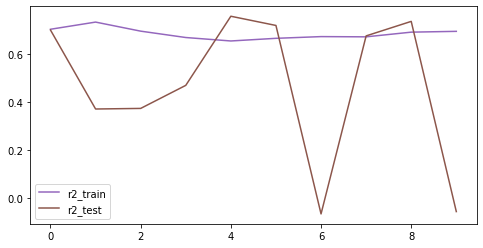

In [37]:
ax = opt_model_hor_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

(0.2, 0.45)

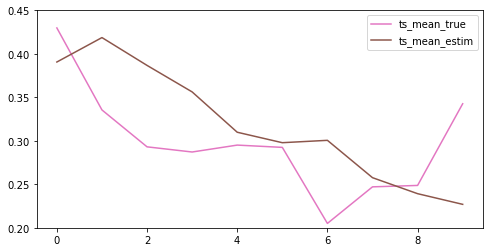

In [38]:
ax = opt_model_hor_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [39]:
results_hor = {'Model': [opt_model_ori],
            'fc_horizon': 1,
            'vif': [vif],
            'mse_tscv_t': [opt_model_hor_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_hor_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_hor_test_scores.mse_train.mean()],
            'mse_test': [opt_model_hor_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_hor_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_hor_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_hor_test_scores.mae_train.mean()],
            'mae_test': [opt_model_hor_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_hor_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_hor_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_hor_test_scores.r2_train.mean()],
            'r2_test': [opt_model_hor_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_hor.get_params()],
            'ts_mean_true': opt_model_hor_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_hor_test_scores.ts_mean_estim.mean(),
              }

## Safe to Excel

In [40]:
results = pd.concat([pd.DataFrame(results_ori), pd.DataFrame(results_hor)])

display(results)

storage_name = filename + '_' + vif + '_' + str(datetime.today().day) + '.xlsx'

pd.DataFrame(results).to_excel(path + 'artifacts' + slash + storage_name, index=None)

,Model,fc_horizon,vif,mse_tscv_t,mse_tscv_v,mse_train,mse_test,mae_tscv_t,mae_tscv_v,mae_train,mae_test,r2_tscv_t,r2_tscv_v,r2_train,r2_test,opt_model,ts_mean_true,ts_mean_estim
0,"ElasticNet(alpha=0.00018308280393208325, l1_ratio=0.975957247005574,\n max_iter=7000, random_state=23)",0,vif_5,0.004002,0.004681,0.004053,0.004805,0.049527,0.053489,0.049889,0.054485,0.856169,0.785029,0.855121,0.774130,"{'alpha': 0.00018308280393208325, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.975957247005574, 'max_iter': 7000, 'positive': False, 'precompute': False, 'random_state': 23, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}",0.296046,0.310514
0,"ElasticNet(alpha=0.00018308280393208325, l1_ratio=0.975957247005574,\n max_iter=7000, random_state=23)",1,vif_5,0.008602,0.009196,0.008601,0.010673,0.074329,0.076642,0.074318,0.083440,0.687589,0.562239,0.686394,0.469351,"{'alpha': 0.000556534412323193, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.9992594109074393, 'max_iter': 7000, 'positive': False, 'precompute': False, 'random_state': 23, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}",0.297655,0.318438
